(least_squares) CSTRs in Series: Estimating Reaction Rate Constants

k1 = 0.8119 ± 0.0083   (true 0.8000)
k2 = 1.4291 ± 0.0473   (true 1.5000)


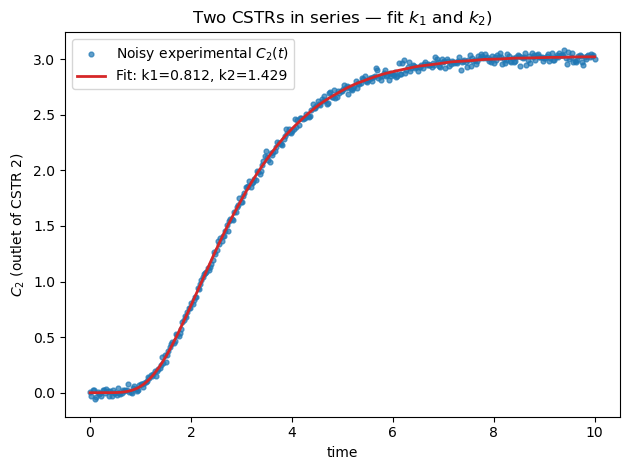

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

# ------------------------- Model (2 CSTRs in series) -------------------
# States: [CA1, CB1, CB2, CC2]
def dydt(t, y, k1, k2, CA0, tau):
    CA1, CB1, CB2, CC2 = y

    # CSTR 1: A -> B  
    r1 = k1 * CA1
    dCA1 = (CA0 - CA1)/tau - r1
    dCB1 = (0.0 - CB1)/tau + r1

    # CSTR 2: B -> C  
    r2 = k2 * CB2**2
    dCB2 = (CB1 - CB2)/tau - r2
    dCC2 = (0.0 - CC2)/tau + r2

    return [dCA1, dCB1, dCB2, dCC2]

def residuals(x_params, t_exp, y_exp, sigma=0.01, CA0=1.0, tau=1.0):
    """Weighted residuals: (measured - model)/sigma."""
    k1, k2 = x_params
    y0 = [0.0, 0.0, 0.0, 0.0]  # Initial conditions: [CA1, CB1, CB2, CC2]
    sol = solve_ivp(
        dydt, (t_exp[0], t_exp[-1]), y0, t_eval=t_exp,
        args=(k1, k2, CA0, tau), rtol=1e-7, atol=1e-9
    )
    if not sol.success:
        return np.full_like(t_exp, 1e9, dtype=float)
    y_pred = sol.y[3]  # CC2(t)
    return (y_exp - y_pred) / sigma

# ------------------------- Synthetic data ------------------------------
# True parameters and setup
k1_true, k2_true = 0.8, 1.5
CA0, tau = 10.0, 1.0

t_end = 10.0
t_exp = np.linspace(0.0, t_end, 400)
sigma = 0.03
rng = np.random.default_rng(42)

# Generate noise-free and noisy CC2 data
y0_true = [0.0, 0.0, 0.0, 0.0]
sol_true = solve_ivp(
    dydt, (t_exp[0], t_exp[-1]), y0_true, t_eval=t_exp,
    args=(k1_true, k2_true, CA0, tau))
C2_true = sol_true.y[3]
C2_exp = C2_true + rng.normal(0, sigma, size=t_exp.size)

# ------------------------- Fit k1, k2 with least_squares ---------------
p0 = np.array([0.5, 0.3])  # initial guess
bounds = (np.array([1e-8, 1e-8]), np.array([5.0, 5.0]))

res = least_squares(
    residuals, p0, bounds=bounds,
    args=(t_exp, C2_exp),
    kwargs={"sigma": sigma, "CA0": CA0, "tau": tau})

k1_fit, k2_fit = res.x

# ------------------------- Uncertainty estimates -----------------------
n, m = t_exp.size, res.x.size
rss = np.sum(res.fun**2)            # weighted RSS
s2  = rss / max(n - m, 1)           # residual variance
J   = res.jac                       # Jacobian at optimum (n x m)
cov = s2 * np.linalg.pinv(J.T @ J)  # (J^T J)^(-1) scaled
se  = np.sqrt(np.diag(cov))
k1_se, k2_se = se

print(f"k1 = {k1_fit:.4f} ± {k1_se:.4f}   (true {k1_true:.4f})")
print(f"k2 = {k2_fit:.4f} ± {k2_se:.4f}   (true {k2_true:.4f})")

# ------------------------- Plot ---------------------------------------
# Simulate fitted model for plotting
y0_plot = [0.0, 0.0, 0.0, 0.0]
sol_fit = solve_ivp(
    dydt, (t_exp[0], t_exp[-1]), y0_plot, t_eval=t_exp,
    args=(k1_fit, k2_fit, CA0, tau),
)
C2_fit = sol_fit.y[3]

plt.figure()
plt.scatter(t_exp, C2_exp, s=12, alpha=0.7, label="Noisy experimental $C_2(t)$")
plt.plot(t_exp, C2_fit, lw=2, label=f"Fit: k1={k1_fit:.3f}, k2={k2_fit:.3f}", color="tab:red")
plt.xlabel("time")
plt.ylabel(r"$C_2$ (outlet of CSTR 2)")
plt.title("Two CSTRs in series — fit $k_1$ and $k_2$)")
plt.legend()
plt.tight_layout()
plt.show()


(curve_fit) CSTRs in Series with variable feed: Estimating Reaction Rate Constants

k1 = 0.9253 ± 0.0004  (true 1.0000)
k2 = 0.8148 ± 0.0021  (true 0.7500)
k3 = 0.4981 ± 0.0020  (true 0.5000)


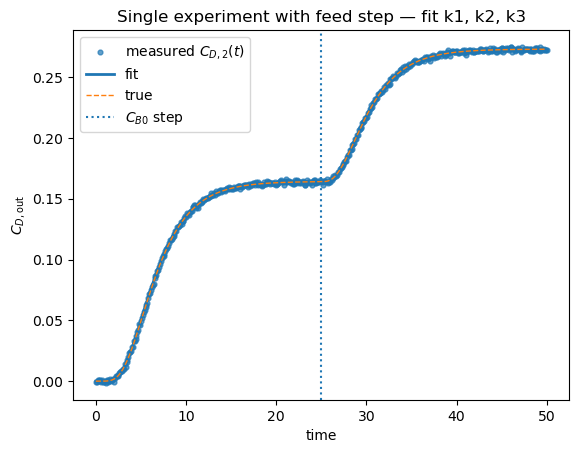

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

# ----- true params & setup -----
k1_true, k2_true, k3_true = 1.00, 0.75, 0.50
tau1, tau2 = 1.5, 3.0
t_end = 50.0
t_eval = np.linspace(0.0, t_end, 500)
sigma = 0.001

# One experiment with a step in B feed (single run)
CA_feed= 1.0
CB_feed_low, CB_feed_high = 0.5, 1.0
t_step = t_end / 2

def CB_feed_fun(t):
    return CB_feed_low if t < t_step else CB_feed_high

# ----- ODE (states: CA1, CB1, CC1, CA2, CB2, CC2, CD2) -----
def rhs(t, y, k1, k2, k3):
    CA1, CB1, CC1, CA2, CB2, CC2, CD2 = y
    CA1p, CB1p, CC1p = np.clip([CA1, CB1, CC1], 0, np.inf)
    CA2p, CB2p, CC2p = np.clip([CA2, CB2, CC2], 0, np.inf)

    CA0 = CA_feed
    CB0 = CB_feed_fun(t)

    r1 = k1 * CA1p * CB1p
    r2 = k2 * CA2p * CC2p
    r3 = k3 * CB2p * CC2p  

    dCA1 = (CA0 - CA1)/tau1 - r1
    dCB1 = (CB0 - CB1)/tau1 - r1
    dCC1 = (0.0 - CC1)/tau1 + r1

    dCA2 = (CA1 - CA2)/tau2 - r2
    dCB2 = (CB1 - CB2)/tau2 - r3
    dCC2 = (CC1 - CC2)/tau2 - r2 - r3
    dCD2 = (0.0 - CD2)/tau2 + r2 + r3
    
    return [dCA1, dCB1, dCC1, dCA2, dCB2, dCC2, dCD2]

def solve_the_ODEs(t_grid, k1, k2, k3):
    y0 = [0,0,0,0,0,0,0]
    sol = solve_ivp(rhs, (t_grid[0], t_grid[-1]), y0, t_eval=t_grid,
                    args=(k1, k2, k3), rtol=1e-7, atol=1e-9)
    if not sol.success:
        return np.full_like(t_grid, 1e9)
    return sol.y[6]

# ----- synthetic data (single experiment with a step in CB0) -----
rng = np.random.default_rng(123)
y_true = solve_the_ODEs(t_eval, k1_true, k2_true, k3_true)
y_meas = y_true + rng.normal(0, sigma, size=t_eval.size)

# ----- model function for curve_fit -----
p0 = (0.8, 0.6, 0.4)
bounds = ((1e-6, 1e-6, 1e-6), (5.0, 5.0, 5.0))

popt, pcov = curve_fit(solve_the_ODEs, t_eval, y_meas, p0=p0, bounds=bounds,
                       sigma=np.full_like(t_eval, sigma), absolute_sigma=True)

k1_hat, k2_hat, k3_hat = popt
k1_se, k2_se, k3_se = np.sqrt(np.diag(pcov))

print(f"k1 = {k1_hat:.4f} ± {k1_se:.4f}  (true {k1_true:.4f})")
print(f"k2 = {k2_hat:.4f} ± {k2_se:.4f}  (true {k2_true:.4f})")
print(f"k3 = {k3_hat:.4f} ± {k3_se:.4f}  (true {k3_true:.4f})")

# ----- plot -----
plt.figure()
plt.scatter(t_eval, y_meas, s=12, alpha=0.7, label="measured $C_{D,2}(t)$")
plt.plot(t_eval, solve_the_ODEs(t_eval, *popt), lw=2, label="fit")
plt.plot(t_eval, y_true, lw=1, linestyle="--", label="true")
plt.axvline(t_step, linestyle=":", lw=1.5, label="$C_{B0}$ step")
plt.xlabel("time"); plt.ylabel("$C_{D,\\mathrm{out}}$")
plt.title("Single experiment with feed step — fit k1, k2, k3")
plt.legend()
plt.show()


(Object Oriented) CSTRs in Series: Estimating Reaction Rate Constants

k1 = 0.8746 ± 0.0142  (true 1.0000)
k2 = 0.8723 ± 0.0211  (true 0.7500)
k3 = 0.4937 ± 0.0085  (true 0.5000)


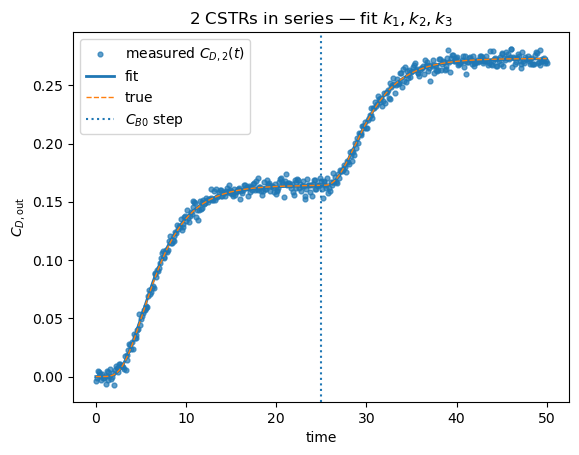

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

class TwoCSTRSeries:
    def __init__(self,
                 tau1=1.5, tau2=3.0,
                 CA_feed=1.0,
                 CB_low=0.5, CB_high=1.0,
                 t_end=50.0, n_points=500,
                 step_fraction=0.5,
                 sigma=0.004,
                 rtol=1e-7, atol=1e-9):
        # Known/experiment settings
        self.tau1 = tau1
        self.tau2 = tau2
        self.CA_feed = CA_feed
        self.CB_low = CB_low
        self.CB_high = CB_high
        self.t_end = t_end
        self.n_points = n_points
        self.step_fraction = step_fraction
        self.sigma = sigma
        self.rtol = rtol
        self.atol = atol

        # Derived time grid
        self.t_eval = np.linspace(0.0, self.t_end, self.n_points)
        self.t_step = self.step_fraction * self.t_end

    # ---- Feed profile (single step in B) ----
    def CB_feed(self, t):
        return self.CB_low if t < self.t_step else self.CB_high

    # ---- ODE RHS: states = [CA1, CB1, CC1, CA2, CB2, CC2, CD2] ----
    def rhs(self, t, y, k1, k2, k3):
        CA1, CB1, CC1, CA2, CB2, CC2, CD2 = y
        # guard tiny negatives
        CA1p, CB1p, CC1p = np.clip([CA1, CB1, CC1], 0.0, np.inf)
        CA2p, CB2p, CC2p = np.clip([CA2, CB2, CC2], 0.0, np.inf)

        CA0 = self.CA_feed
        CB0 = self.CB_feed(t)

        # Tank 1: A + B -> C
        r1 = k1 * CA1p * CB1p
        dCA1 = (CA0 - CA1)/self.tau1 - r1
        dCB1 = (CB0 - CB1)/self.tau1 - r1
        dCC1 = (0.0 - CC1)/self.tau1 + r1

        # Tank 2: A + C -> D,  B + C -> D  
        r2 = k2 * CA2p * CC2p
        r3 = k3 * CB2p * CC2p
        dCA2 = (CA1 - CA2)/self.tau2 - r2
        dCB2 = (CB1 - CB2)/self.tau2 - r3
        dCC2 = (CC1 - CC2)/self.tau2 - r2 - r3
        dCD2 = (0.0 - CD2)/self.tau2 + r2 + r3

        return [dCA1, dCB1, dCC1, dCA2, dCB2, dCC2, dCD2]

    # ---- Simulator used by curve_fit ----
    def simulate_CD2(self, t, k1, k2, k3):
        y0 = [0, 0, 0, 0, 0, 0, 0]
        sol = solve_ivp(self.rhs, (t[0], t[-1]), y0, t_eval=t,
                        args=(k1, k2, k3), rtol=self.rtol, atol=self.atol)
        if not sol.success:
            # penalize failure so optimizer avoids this region
            return np.full_like(t, 1e9, dtype=float)
        return sol.y[6]  # CD2(t)

    # Wrapper with signature model(t, *params_to_fit)
    def model(self, t, k1, k2, k3):
        return self.simulate_CD2(t, k1, k2, k3)
    
    # ---- Fit k1,k2,k3 from CD2(t) ----
    def fit(self, y_meas, p0=(0.8, 0.6, 0.4),
            bounds=((1e-6, 1e-6, 1e-6), (5.0, 5.0, 5.0)),
            maxfev=6000):
        popt, pcov = curve_fit(self.model,
                               self.t_eval, y_meas,
                               p0=p0, bounds=bounds,
                               sigma=np.full_like(self.t_eval, self.sigma),
                               absolute_sigma=True, maxfev=maxfev)
        se = np.sqrt(np.diag(pcov))
        return popt, se, pcov

    # ---- Synthetic data generator ----
    def make_synthetic(self, k1_true, k2_true, k3_true, seed=123):
        rng = np.random.default_rng(seed)
        y_true = self.model(self.t_eval, k1_true, k2_true, k3_true)
        y_meas = y_true + rng.normal(0, self.sigma, size=self.t_eval.size)
        return y_true, y_meas

    # ---- Quick plot ----
    def plot_fit(self, y_meas, popt, y_true=None, show_step=True):
        plt.figure()
        plt.scatter(self.t_eval, y_meas, s=12, alpha=0.7, label="measured $C_{D,2}(t)$")
        plt.plot(self.t_eval, self.model(self.t_eval, *popt), lw=2, label="fit")
        if y_true is not None:
            plt.plot(self.t_eval, y_true, lw=1, linestyle="--", label="true")
        if show_step:
            plt.axvline(self.t_step, linestyle=":", lw=1.5, label="$C_{B0}$ step")
        plt.xlabel("time"); plt.ylabel("$C_{D,\\mathrm{out}}$")
        plt.title("2 CSTRs in series — fit $k_1,k_2,k_3$")
        plt.legend(); plt.show()


# Truths
k1_true, k2_true, k3_true = 1.00, 0.75, 0.50

# Build model 
CstrsModel = TwoCSTRSeries(
    tau1=1.5, tau2=3.0,
    CA_feed=1.0,
    CB_low=0.5, CB_high=1.0,    
    t_end=50.0, n_points=500, sigma=0.004
)

# generate synthetic data
y_true, y_meas = CstrsModel.make_synthetic(k1_true, k2_true, k3_true)

# fit
popt, se, _ = CstrsModel.fit(y_meas)
print(f"k1 = {popt[0]:.4f} ± {se[0]:.4f}  (true {k1_true:.4f})")
print(f"k2 = {popt[1]:.4f} ± {se[1]:.4f}  (true {k2_true:.4f})")
print(f"k3 = {popt[2]:.4f} ± {se[2]:.4f}  (true {k3_true:.4f})")

# visualize
CstrsModel.plot_fit(y_meas, popt, y_true=y_true)
